<img src="../_images/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

# Classification with FACET: Prediabetes Study

FACET is composed of the following key components:

- **Model Inspection**

    FACET introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about FACET's model inspection capabilities, see the getting started example below.


- **Model Simulation**

    FACET's model simulation algorithms use ML models for *virtual experiments* to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, FACET utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of FACET’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    FACET offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. FACET also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.    

***

**Context**

Prediabetes is a treatable condition that leads to many health complications and eventually type 2 diabetes. Identification of individuals at risk of prediabetes can improve early intervention and provide insights into those interventions that work best.
Using a cohort of healthy (*n*=2847) and prediabetic (*n*=1509) patients derived 
from the [NHANES 2013-14 U.S. cross-sectional survey](https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Examination&CycleBeginYear=2013) we aim to create a classifier for prediabetes. For further details on data sources, definitions and the study cohort please see the Appendix ([Data source and study cohort](#Data-source-and-study-cohort)).

Utilizing FACET, we will do the following:

1. create a pipeline to find identify a well-performing classifier.
2. perform model inspection and simulation to gain understanding and insight into key factors predictive of prediabetes.

***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [Preprocessing and initial feature selection](#Preprocessing-and-initial-feature-selection)
3. [Selecting a learner using FACET selector](#Selecting-a-learner-using-FACET-selector)
4. [Using FACET for advanced model inspection](#Using-FACET-for-advanced-model-inspection)
5. [FACET univariate simulator: the impact of waist to height ratio](#FACET-univariate-simulator:-the-impact-of-waist-to-height-ratio)
6. [Summary](#Summary)
7. [What can you do next?](#What-can-you-do-next?)
8. [Appendix](#Appendix)

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


# ignore irrelevant warnings that would affect the output of this tutorial notebook

import warnings
import tableone # need to import this to suppress an IPython warning triggered by tableone

warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")
warnings.filterwarnings("ignore", message=r".*`should_run_async` will not call `transform_cell`")
warnings.filterwarnings("ignore", message=r".*`np\..*` is a deprecated alias")
warnings.filterwarnings("ignore", message=r"Importing display from IPython.core.display is deprecated.*")


# set global options for matplotlib

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (12.0, 6.0)
matplotlib.rcParams["figure.dpi"] = 96

# Required imports

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, etc.)
2. Required FACET classes (inspection, selection, validation, simulation, etc.)
3. Other BCG GAMMA packages which simplify pipelining (sklearndf, see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)) and support visualization (pytools, see on [GitHub](https://github.com/BCG-Gamma/pytools)) when using FACET

**Common package imports**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import shap
import seaborn as sns
from sklearn.compose import make_column_selector
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV

**FACET imports**

In [3]:
from facet.data import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerSelector, ParameterSpace
from facet.validation import BootstrapCV
from facet.data.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateProbabilitySimulator
from facet.simulation.viz import SimulationDrawer

**sklearndf imports**

Instead of using the "regular" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas data frames. Additionally, the names of all your favourite scikit-learn functions are the same except for `DF` on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`

In [4]:
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.classification.extra import LGBMClassifierDF
from sklearndf.transformation import (
    ColumnTransformerDF,
    OneHotEncoderDF,
    SimpleImputerDF,
)
from sklearndf.transformation.extra import BorutaDF

**pytools imports**

pytools (see on [GitHub](https://github.com/BCG-Gamma/pytools)) is an open source library containing general machine learning and visualization utilities, some of which are useful for visualising the advanced model inspection capabilities of FACET.

In [5]:
from pytools.viz.dendrogram import DendrogramDrawer
from pytools.viz.matrix import MatrixDrawer

# Preprocessing and initial feature selection

First we need to load our prediabetes data and create a simple preprocessing pipeline. For those interested some initial EDA can be found in the Appendix ([Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))).

In [6]:
# load the prepared data frame
prediab_df = pd.read_csv("pre_diab_nhanes.csv")

# create a couple of new interesting features
prediab_df["SBP_to_DBP"] = prediab_df["Average_SBP"] / prediab_df["Average_DBP"]
prediab_df["Waist_to_hgt"] = (
    prediab_df["Waist_Circumference"] / prediab_df["Standing_Height"]
)

# make clear based on dtypes these two features are categorical
prediab_df["General_health"] = prediab_df["General_health"].astype("object")
prediab_df["Healthy_diet"] = prediab_df["Healthy_diet"].astype("object")

# have a look
prediab_df.head().T

,0,1,2,3,4
Age,73.0,56.0,61.0,56.0,65.0
Gender,2.0,1.0,2.0,2.0,1.0
Waist_Circumference,NaN,123.1,110.8,85.5,93.7
Weight,52.0,105.0,93.4,61.8,65.3
Standing_Height,162.4,158.7,161.8,152.8,172.4
BMI,19.7,41.7,35.7,26.5,22.0
Average_SBP,137.333333,157.333333,122.666667,122.0,141.333333
Average_DBP,86.666667,82.0,80.666667,72.666667,77.333333
HDL_Cholesterol,85.0,38.0,58.0,59.0,79.0
Total_Cholesterol,201.0,226.0,168.0,278.0,173.0


In [7]:
# to ensure a quick run we will use a random sample of 1000 observations
prediab_df = prediab_df.sample(n=1000, random_state=42)

For easier data management we will create a sample object using FACET's `Sample` class, which allows us to: 

- Quickly access the target vs. features
- Pass our data into sklearndf pipelines
- Pass information to other FACET functions

In [8]:
# create a FACET sample object
prediab = Sample(
    observations=prediab_df,
    feature_names=prediab_df.drop(columns=["Pre_diab"]).columns,
    target_name="Pre_diab",
)

Next we create a minimum preprocessing pipeline which based on our initial EDA ([Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))) needs to address the following:

1. Simple imputation for missing values in both continuous and categorical features
2. One-hot encoding for categorical features

We will use the sklearndf wrappers for scikit-learn functions such as `SimpleImputerDF` in place of `SimpleImputer`, `OneHotEncoderDF` in place of `OneHotEncoder`, and so on.

In [9]:
# for categorical features we will use the mode as the imputation value and also one-hot encode
preprocessing_categorical = PipelineDF(
    steps=[
        ("imputer", SimpleImputerDF(strategy="most_frequent", fill_value="<na>")),
        ("one-hot", OneHotEncoderDF(sparse=False, handle_unknown="ignore")),
    ]
)

# for numeric features we will impute using the median
preprocessing_numerical = SimpleImputerDF(strategy="median")

# put the pipeline together
preprocessing_features = ColumnTransformerDF(
    transformers=[
        (
            "categorical",
            preprocessing_categorical,
            make_column_selector(dtype_include=object),
        ),
        (
            "numerical",
            preprocessing_numerical,
            make_column_selector(dtype_include=np.number),
        ),
    ],
    verbose_feature_names_out=False,
)

Next, we perform some initial feature selection using Boruta, a recent approach shown to have quite good performance. The Boruta algorithm removes features that are no more predictive than random noise. If you are interested further, please see this  [article](https://www.jstatsoft.org/article/view/v036i11).

The `BorutaDF` transformer in our sklearndf package provides easy access to this powerful method. The approach relies on a tree-based learner, usually a random forest. For settings, a `max_depth` of between 3 and 7 is typically recommended, and here we rely on the default setting of 5. However, as this depends on the number of features and the complexity of interactions one could also explore the sensitivity of feature selection to this parameter. The number of trees is automatically managed by the Boruta feature selector argument `n_estimators="auto"`.

We also use parallelization for the random forest using `n_jobs` to accelerate the Boruta iterations.

In [10]:
# create the pipeline for Boruta
boruta_feature_selection = PipelineDF(
    steps=[
        ("preprocessing", preprocessing_features),
        (
            "boruta",
            BorutaDF(
                estimator=RandomForestClassifierDF(
                    max_depth=5, n_jobs=-3, random_state=42
                ),
                n_estimators="auto",
                random_state=42,
                verbose=False,
            ),
        ),
    ]
)

# run feature selection using Boruta and report those selected
boruta_feature_selection.fit(X=prediab.features, y=prediab.target)
selected = boruta_feature_selection.feature_names_original_.unique()
selected

array(['Age', 'Waist_Circumference', 'BMI', 'Average_SBP', 'RBC_count',
       'Hematocrit', 'Uric_acid', 'Gamma_glutamyl_transferase',
       'SBP_to_DBP', 'Waist_to_hgt'], dtype=object)

Boruta identified 10 features (out of a potential 47) that we will retain in our FACET sample object for classification. Note that this feature selection process could be included in a general preprocessing pipeline, however due to the computation involved, we have utilized Boruta here as an initial one-off processing step to narrow down the features for our classifier development.

In [11]:
# update FACET sample object to only those features Boruta identified as useful
prediab_initial_features = prediab.keep(feature_names=selected)

# Selecting a learner using FACET

FACET implements several additional useful wrappers which further simplify comparing and tuning a larger number of models and configurations: 

- `ParameterSpace`: allows you to pass a learner pipeline (i.e., classifier + any preprocessing) and a set of hyperparameters
- `LearnerSelector`: one or more ParameterSpaces can be passed into this class - this allows tuning hyperparameters across different types of learners in a single step and ranks the resulting models accordingly

The following learners and hyperparameter ranges will be assessed using 10 repeated 5-fold cross-validation:


1. **Random forest**: with hyperparameters
    - max_depth: [4..7]
    - min_samples_leaf: [8..19]; smaller ints are more frequent (zipfian distribution)
    - n_estimators: [20..300]; smaller ints are more frequent (zipfian distribution)
  
2. **Light gradient boosting**: with hyperparameters
    - max_depth: [4..7]
    - min_child_samples: [8..19]; smaller ints are more frequent (zipfian distribution)  
    - n_estimators: [20..300]; smaller ints are more frequent (zipfian distribution)

Note if you want to see a list of hyperparameter names you can use `<ClassifierClass>().get_params().keys()` where `<ClassifierClass>` could be for example `RandomForestClassifierDF` and if you want to see the default values, just use `<ClassifierClass>().get_params()`.

Finally, for this exercise we will use accuracy as the default performance metric for scoring and ranking our classifiers.

First, we specify the classifiers we want to train using `ClassifierPipelineDF` from sklearndf. Note here we also include the feature preprocessing steps we created earlier.

In [12]:
# random forest learner
rforest_clf = ClassifierPipelineDF(
    preprocessing=preprocessing_features,
    classifier=RandomForestClassifierDF(random_state=42),
)

# light gradient boosting learner
lgbm_clf = ClassifierPipelineDF(
    preprocessing=preprocessing_features,
    classifier=LGBMClassifierDF(random_state=42)
)

Then we create parameter spaces with `ParameterSpace` for each classifier and specify set of hyperparameters for each one of them. Contrary to standard `sklearn` workflow, in this approach setting wrong hyperparameter will throw an exception as setting an attribute comes with a proper check. 

In [13]:
rforest_ps = ParameterSpace(rforest_clf)

# random ints 4 <= x <= 7
rforest_ps.classifier.max_depth = stats.randint(4, 8)
# random ints 8 <= x <= 19; smaller ints are more frequent (zipfian distribution)
rforest_ps.classifier.min_samples_leaf = stats.zipfian(a=1, n=12, loc=7)
# random ints 20 <= x < 300; smaller ints are more frequent (zipfian distribution)
rforest_ps.classifier.n_estimators = stats.zipfian(a=1/2, n=380, loc=20)

lgbm_ps = ParameterSpace(lgbm_clf)

# random ints 4 <= x <= 7
lgbm_ps.classifier.max_depth = stats.randint(4, 8)
# random ints 8 <= x <= 19; smaller ints are more frequent (zipfian distribution)
lgbm_ps.classifier.min_child_samples = stats.zipfian(a=1, n=12, loc=7)
# random ints 20 <= x < 300; smaller ints are more frequent (zipfian distribution)
lgbm_ps.classifier.n_estimators = stats.zipfian(a=1/2, n=380, loc=20)
lgbm_ps.classifier.subsample = stats.uniform(0.8, 0.2)

We now fit a `LearnerSelector` using the parameter spaces defined above, running a random search using 10 repeated 5-fold cross-validation on our selected set of features from Boruta (`LearnerSelector` supports any CV approach implementing class `BaseSearchCV`).

In [14]:
clf_selector = LearnerSelector(
    searcher_type=RandomizedSearchCV,
    parameter_space=[rforest_ps, lgbm_ps],
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring="roc_auc",
    random_state=42,
).fit(prediab_initial_features)

We can see how each model scored using the `summary_report()` method of the `LearnerSelector`.

In [15]:
# let's look at performance for the top ranked classifiers
clf_selector.summary_report()

score                                     candidate      param  \
   test                                             - classifier   
   rank      mean       std                         -  max_depth   
2     1  0.725129  0.033742  RandomForestClassifierDF          6   
9     2  0.724997  0.032834  RandomForestClassifierDF          5   
0     3  0.724842  0.032747  RandomForestClassifierDF          7   
7     4  0.723124  0.033567  RandomForestClassifierDF          5   
1     5  0.718529  0.034161  RandomForestClassifierDF          4   
5     6  0.710667  0.031914          LGBMClassifierDF          4   
4     7  0.709203  0.027709          LGBMClassifierDF          5   
6     8  0.698365  0.030459          LGBMClassifierDF          7   
8     9  0.692535  0.029564          LGBMClassifierDF          4   
3    10  0.685510  0.028177          LGBMClassifierDF          6   

                                                                 time  \
                                                                  fit   
  min_samples_leaf n_estimators min_child_samples subsample      mean   
2               15          164               NaN       NaN  0.135929   
9               18          376               NaN       NaN  0.304241   
0               18          230               NaN       NaN  0.194192   
7                8          128               NaN       NaN  0.107344   
1                8           33               NaN       NaN  0.028277   
5              NaN           58                 9  0.922371  0.011555   
4              NaN           37                 8  0.860848  0.011761   
6              NaN           78                 8  0.891214  0.023414   
8              NaN          167                 8  0.834105  0.023739   
3              NaN          379                 8  0.966489  0.078497   

                                 
                score            
        std      mean       std  
2  0.002942  0.008452  0.000312  
9  0.017114  0.016190  0.000974  
0  0.011951  0.011218  0.000494  
7  0.005442  0.007033  0.000470  
1  0.000811  0.003479  0.000201  
5  0.000390  0.002386  0.000164  
4  0.000773  0.002461  0.000338  
6  0.000938  0.002875  0.000229  
8  0.001152  0.002916  0.000286  
3  0.002283  0.004991  0.000202

We can see based on our `LearnerSelector`, we have selected a Random Forest algorithm that achieved a mean accuracy of 0.725 with a SD of 0.034.

# Using FACET for advanced model inspection

The [SHAP approach](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for each observation (i.e., explain **individual** predictions).

The FACET `LearnerInspector` computes SHAP values for each observation using the best model identified by the `LearnerSelector`. The FACET `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding pairwise feature redundancy and synergy. Redundancy and synergy are calculated using a new algorithm to understand model predictions from a **global perspective** to complement local SHAP.

The definitions of synergy and redundancy are as follows:

- **Synergy**

  The degree to which the model combines information from one feature with 
  another to predict the target. For example, let's assume we are predicting 
  cardiovascular health using age and gender and the fitted model includes 
  a complex interaction between them. This means these two features are 
  synergistic for predicting cardiovascular health. Further, both features 
  are important to the model and removing either one would significantly 
  impact performance. Let's assume age brings more information to the joint
  contribution than gender. This asymmetric contribution means the synergy for
  (age, gender) is less than the synergy for (gender, age). To think about it
  another way, imagine the prediction is a coordinate you are trying to reach.
  From your starting point, age gets you much closer to this point than 
  gender, however, you need both to get there. Synergy reflects the fact 
  that gender gets more help from age (higher synergy from the perspective 
  of gender) than age does from gender (lower synergy from the perspective of
  age) to reach the prediction. *This leads to an important point: synergy 
  is a naturally asymmetric property of the global information two interacting 
  features contribute to the model predictions.* Synergy is expressed as a 
  percentage ranging from 0% (full autonomy) to 100% (full synergy).


- **Redundancy**

  The degree to which a feature in a model duplicates the information of a 
  second feature to predict the target. For example, let's assume we had 
  house size and number of bedrooms for predicting house price. These 
  features capture similar information as the more bedrooms the larger 
  the house and likely a higher price on average. The redundancy for 
  (number of bedrooms, house size) will be greater than the redundancy 
  for (house size, number of bedrooms). This is because house size 
  "knows" more of what number of bedrooms does for predicting house price 
  than vice-versa. Hence, there is greater redundancy from the perspective 
  of number of bedrooms. Another way to think about it is removing house 
  size will be more detrimental to model performance than removing number 
  of bedrooms, as house size can better compensate for the absence of 
  number of bedrooms. This also implies that house size would be a more 
  important feature than number of bedrooms in the model. *The important 
  point here is that like synergy, redundancy is a naturally asymmetric 
  property of the global information feature pairs have for predicting 
  an outcome.* Redundancy is expressed as a percentage ranging from 0% 
  (full uniqueness) to 100% (full redundancy).


Note that cases can apply at the same time so a feature pair can use some information synergistically and some information redundantly.

The FACET `LearnerInspector` can calculate all of this with a single method call, but also offers methods to access the intermediate results of each step. A lightweight visualization framework is available to render the results in different styles.

SHAP values from the `LearnerInspector` can also be used with the SHAP package plotting functions for sample and observation level SHAP visualizations, such as SHAP distribution plots, dependency plots, force plots and waterfall plots.

In [16]:
# run inspector
clf_inspector = LearnerInspector(
    pipeline=clf_selector.best_estimator_,
    n_jobs=-3,
    verbose=False,
).fit(sample=prediab_initial_features)

## Feature importance

Feature importance has many ways of being measured. Here we utilize the FACET implementation based on the `LearnerInspector`. Each feature is ranked according to the mean SHAP value for that feature. This plot is paired with a standard SHAP distribution plot for features to see if there is any directional tendency for the associations.

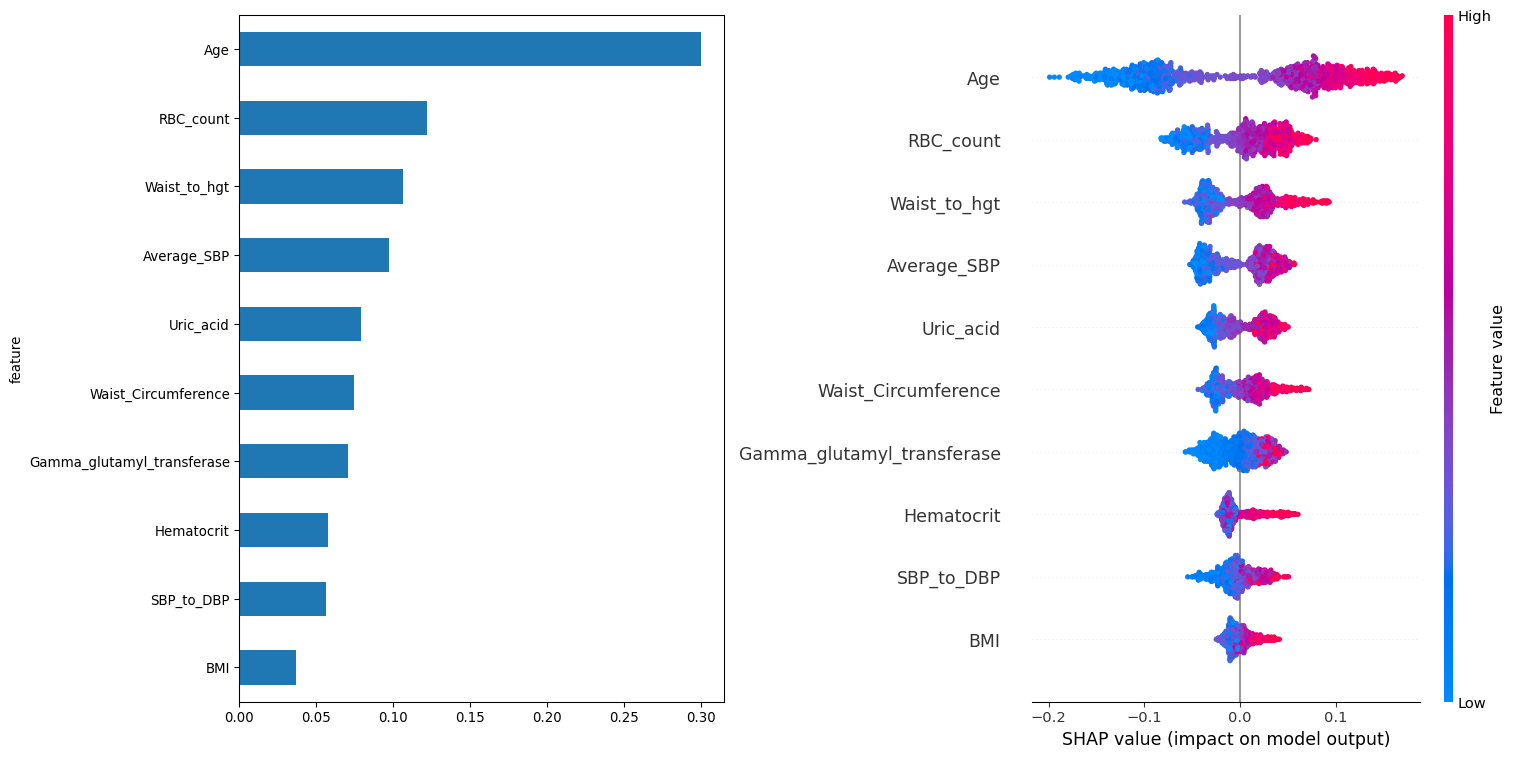

In [17]:
# FACET feature importance
f_importance = clf_inspector.feature_importance()
plt.subplot(1, 2, 1)
f_importance.sort_values().plot.barh()

# get some info for standard SHAP model inspection
shap_data = clf_inspector.shap_plot_data()

# standard SHAP summary plot using the shap package
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values=shap_data.shap_values, features=shap_data.features, show=False, plot_size=(16.0, 8.0))
plt.tight_layout()

Based on the feature importance's we can see the top five features are age, RBC count, waist to height ratio, average systolic blood pressure and waist circumference. Inspection of the SHAP value distributions does not provide any indication of a general direction of association for any features.

## Synergy

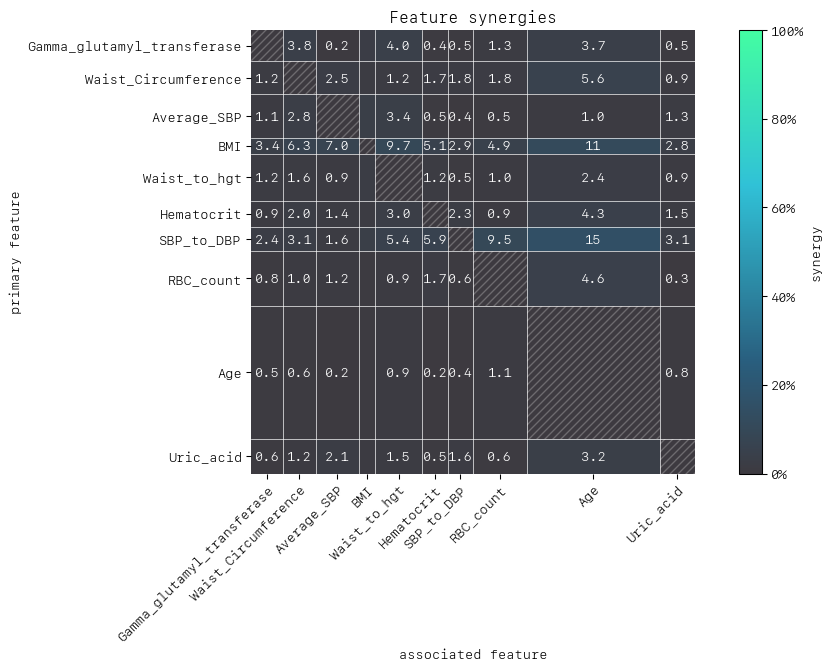

In [18]:
# synergy heatmap
synergy_matrix = clf_inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Feature synergies")

To interpret pairs of features in the synergy matrix, rows represent the *primary feature* ("perspective from"), and the columns represent *associated features*. Column and row widths indicate relative feature importance.

For example, for (`SBP_to_DBP`, `RBC_count`) from the perspective of primary feature `SBP_to_DBP` we find that 9.5% of its contribution to predict prediabetes risk is enabled by context from associated feature `RBC_count`, whereas `RBC_count`'s dependence on context from `SBP_to_DBP` is negligible.

Another interesting observation is that looking at the column for `Age` from the perspective of other features such as `BMI`, `RBC count` and `SBP_to_DBP`, we see values ranging up to 15% suggesting that contributions of `BMI`, `RBC count` and `SBP/DBP` to predicting prediabetes are partly enabled by `Age`. By contrast, `Age` is a strong independent feature. It has the highest feature importance, as indicated by the column and row width of the matrix.

We can inspect synergistic pairs of features more deeply using the *SHAP dependence plots* offered by the SHAP package. The `LearnerInspector` provides all data required for creating these and other plots through method
`shap_plot_data()`:

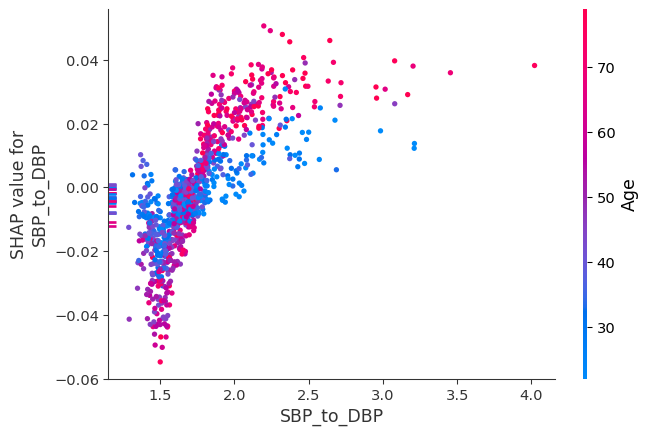

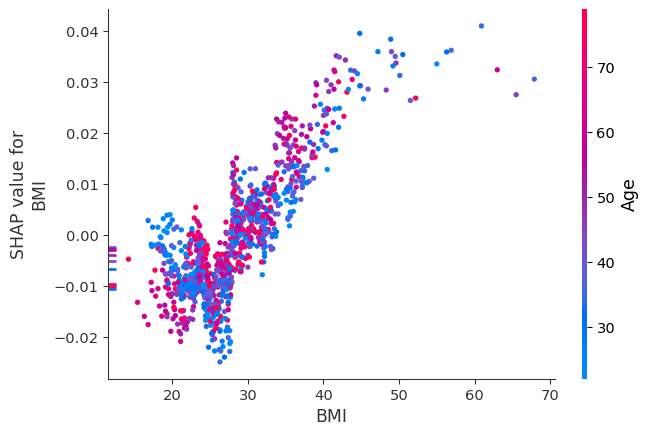

In [19]:
spd = clf_inspector.shap_plot_data()
shap.dependence_plot("SBP_to_DBP", spd.shap_values, spd.features, interaction_index="Age")
shap.dependence_plot("BMI", spd.shap_values, spd.features, interaction_index="Age")

## Redundancy

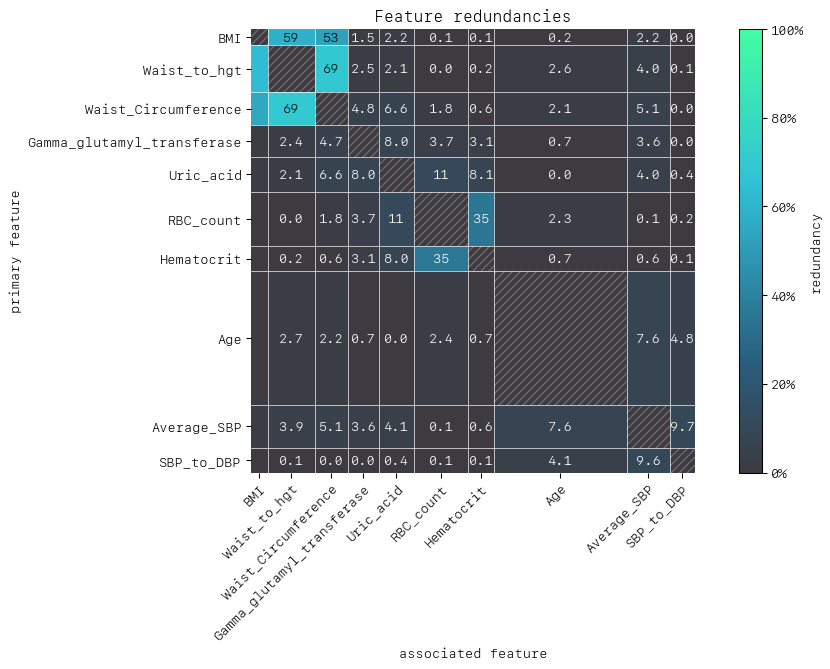

In [20]:
# redundancy heatmap
redundancy_matrix = clf_inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Feature redundancies")

As with synergy, the matrix row is the primary feature ("perspective from") in the row-column feature pair. Let's take `Hematocrit` and `RBC count` as our features of interest. We can see that from the perspective of `Hematocrit` 35% of the information is duplicated with `RBC count` to predict prediabetes, and vice versa.

A second interesting and perhaps expected attribute of the heatmap is the apparent clustering of `BMI`, `Waist Circumference` and `Waist/Height`. Intuitively it makes sense that these features would have varying degrees of redundancy among them, given they are physically related.

## Feature clustering

As detailed above redundancy and synergy for a feature pair is from the "perspective" of one of the features in the pair, and so yields two distinct values. However, a symmetric version can also be computed that provides not only a simplified perspective but allows the use of (1 - metric) as a feature distance. With this distance, hierarchical, single linkage clustering is applied to create a dendrogram visualization. This helps to identify groups of low distance features which work "in tandem" to predict the outcome. Such information can then be used to either reduce clusters of highly redundant features to a subset or highlight clusters of highly synergistic features that should always be considered together.

For this example, let's apply clustering to redundancy to see how the apparent grouping observed in the heatmap appears in the dendrogram. Ideally, we want to see features only start to cluster as close to the right-hand side of the dendrogram as possible. This implies all features in the model are contributing uniquely to our predictions.

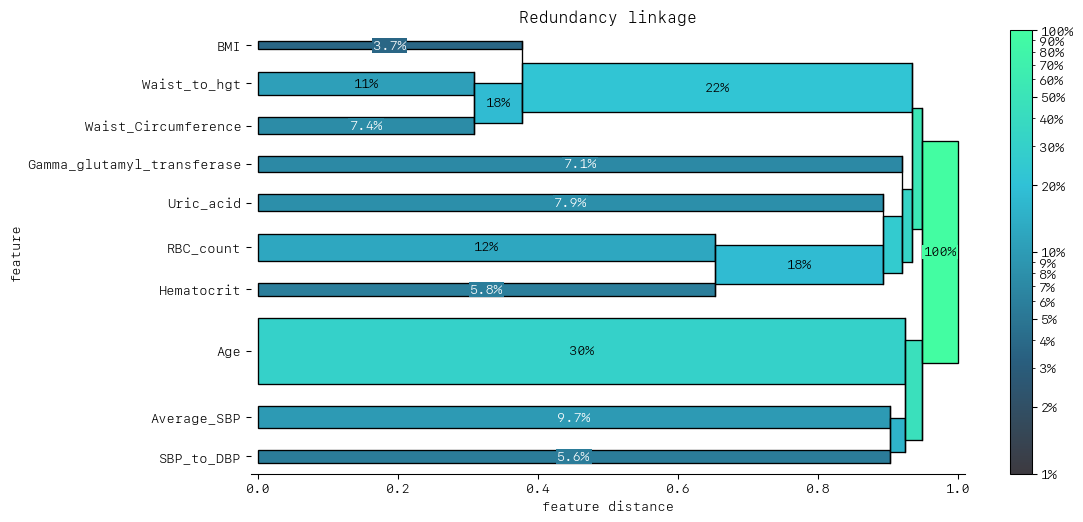

In [21]:
# redundancy dendrogram
dd_redundancy = clf_inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=dd_redundancy)

The dendrogram shows that `Waist Circumference` and `Waist/Height` cluster together first, which then cluster with `BMI` as well. This is a much clearer representation of the cluster of redundant features we observed in the heatmap. Considering `BMI`, `Waist Circumference` and `Waist/Height`:

**What might we infer from synergy, redundancy and redundancy feature clustering?**

1. `BMI`, `Waist Circumference` and `Waist/Height` form a small cluster of redundant features. This seems reasonable:
    * `Waist Circumference` is included in the calculation of `Waist/Height`
    * we might expect `BMI` to capture similar information about excess body mass as higher `Waist Circumference` and `Waist/Height`
2. We saw little synergy between features. We might have expected apriori to find some interesting synergies between diet, exercise, sleep and body composition. Of course, the model needs to identify these relationships from them to be reflected in the synergy metric(s).

**What action(s) might we take?**

Given the redundancy that appears between `BMI`, `Waist Circumference` and `Waist/Height`, we could look to eliminate one or two of these features from the model.

For convenience when working in a non-notebook environment, all of the `Drawer`'s provided by the [pytools](https://github.com/BCG-Gamma/pytools) package also support a `style='text'` flag.

In [22]:
DendrogramDrawer(style="text").draw(title="Redundancy linkage", data=dd_redundancy)

============================== Redundancy linkage ==============================

BMI              4% ----------------------\
Waist_to_hgt    11% ------------------\___/---------------------------------\
Waist_Circumfer  7% ------------------/                                     |
Gamma_glutamyl_  7% -------------------------------------------------------\\
Uric_acid        8% -----------------------------------------------------\ ||__
RBC_count       12% ---------------------------------------\_____________/-/|
Hematocrit       6% ---------------------------------------/                |
Age             30% -------------------------------------------------------\|
Average_SBP     10% ------------------------------------------------------\//
SBP_to_DBP       6% ------------------------------------------------------/



## Removing redundant features

Recall the redundancy dendrogram above where we saw a clear cluster of features with redundancy; `Waist/Height`, `BMI`, and `Waist Circumference`.

- assess if the features of the model are unique, i.e. not redundant with other features
- decide which features to discard, combine, or modify to increase the uniqueness of important features in the model

Before we proceed to looking at SHAP values for individual predictions and perform a univariate simulation, let's eliminate two partially redundant features - we will choose to keep `Waist/Height` ratio and drop `BMI` and `Waist Circumference`. 

In [23]:
# drop redundant features from our FACET sample object
prediab_no_redundant_feat = prediab_initial_features.drop(
    feature_names=["BMI", "Waist_Circumference"]
)

In [24]:
clf_selector = LearnerSelector(
    searcher_type=RandomizedSearchCV,
    parameter_space=[rforest_ps, lgbm_ps],
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring="roc_auc",
    random_state=42,
).fit(prediab_no_redundant_feat)

clf_selector.summary_report()

score                                     candidate      param  \
   test                                             - classifier   
   rank      mean       std                         -  max_depth   
0     1  0.730649  0.033252  RandomForestClassifierDF          7   
9     2  0.729762  0.033654  RandomForestClassifierDF          5   
2     3  0.729191  0.032447  RandomForestClassifierDF          6   
7     4  0.728881  0.033787  RandomForestClassifierDF          5   
1     5  0.723997  0.034597  RandomForestClassifierDF          4   
5     6  0.717630  0.029876          LGBMClassifierDF          4   
4     7  0.714231  0.031225          LGBMClassifierDF          5   
6     8  0.700294  0.031576          LGBMClassifierDF          7   
8     9  0.696527  0.032738          LGBMClassifierDF          4   
3    10  0.684973  0.032143          LGBMClassifierDF          6   

                                                                 time  \
                                                                  fit   
  min_samples_leaf n_estimators min_child_samples subsample      mean   
0               18          230               NaN       NaN  0.163255   
9               18          376               NaN       NaN  0.267629   
2               15          164               NaN       NaN  0.116502   
7                8          128               NaN       NaN  0.097372   
1                8           33               NaN       NaN  0.025100   
5              NaN           58                 9  0.922371  0.010459   
4              NaN           37                 8  0.860848  0.010239   
6              NaN           78                 8  0.891214  0.020512   
8              NaN          167                 8  0.834105  0.022742   
3              NaN          379                 8  0.966489  0.067832   

                                 
                score            
        std      mean       std  
0  0.011057  0.011816  0.005582  
9  0.019498  0.017950  0.007206  
2  0.003290  0.008389  0.000300  
7  0.010087  0.008520  0.003782  
1  0.000913  0.003405  0.000173  
5  0.000463  0.002328  0.000127  
4  0.000386  0.002252  0.000156  
6  0.000915  0.002845  0.000243  
8  0.004056  0.003137  0.001046  
3  0.001911  0.004945  0.000251

In [25]:
# run inspector
inspector_no_redun = LearnerInspector(
    pipeline=clf_selector.best_estimator_,
    n_jobs=-3,
    verbose=False,
).fit(sample=prediab_no_redundant_feat)

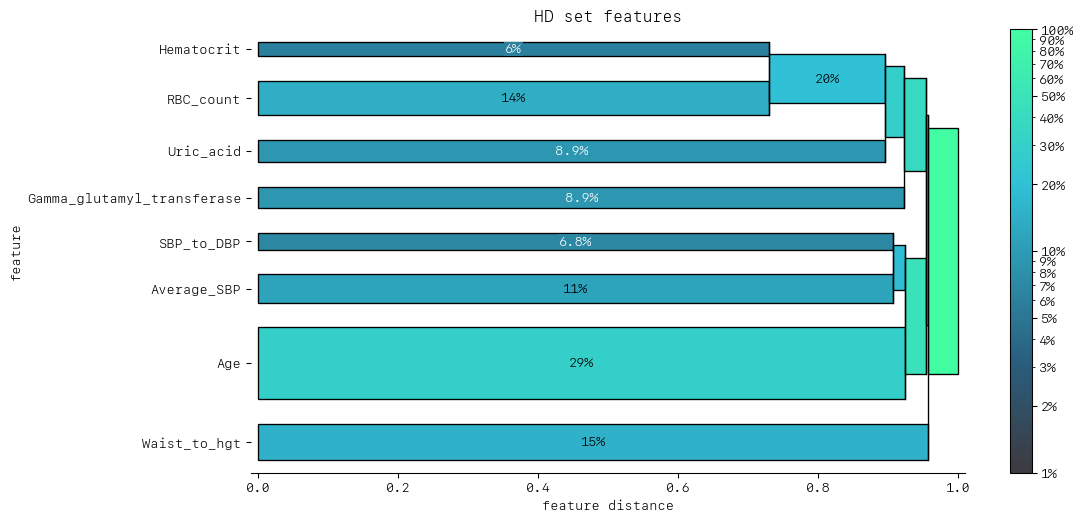

In [26]:
# redundancy dendrogram
dd_redundancy = inspector_no_redun.feature_redundancy_linkage()
DendrogramDrawer().draw(title="HD set features", data=dd_redundancy)

Now with the removal of `BMI` and `Waist Circumference` we can see the feature clustering starts much further to the right.

We can also check the best ranked model after removing redundant features.

In [27]:
clf_selector.best_estimator_.classifier

RandomForestClassifierDF(max_depth=7, min_samples_leaf=18, n_estimators=230, random_state=42)

# FACET univariate simulator: the impact of waist to height ratio

Another advantage of FACET is the ability to quickly instigate and run univariate simulation.
Simulation enables us to gain insight into what value(s) of this ratio might minimize the likelihood of prediabetes.

As the basis for the simulation, we divide the feature into relevant partitions: 

- We use FACET's `ContinuousRangePartitioner` to split the range of observed values of waist to height ratio into intervals of equal size. Each partition is represented by the central value of that partition. 
- For each partition, the simulator creates an artificial copy of the original sample assuming the variable to be simulated has the same value across all observations - which is the value representing the partition. Using the best estimator acquired from the selector, the simulator now re-predicts all targets using the models trained on full sample and determines the average value of the target variable resulting from this.
- The FACET `SimulationDrawer` allows us to visualise the result; both in a matplotlib and a plain-text style

In [28]:
# set up and run a simulation
sim_feature = "Waist_to_hgt"

waist_to_hgt_simulator = UnivariateProbabilitySimulator(
    model=clf_selector.best_estimator_,
    sample=prediab_no_redundant_feat,
    n_jobs=-1,
)

waist_to_hgt_partitions = ContinuousRangePartitioner()

waist_to_hgt_simulation = waist_to_hgt_simulator.simulate_feature(
    feature_name=sim_feature,
    partitioner=waist_to_hgt_partitions
)

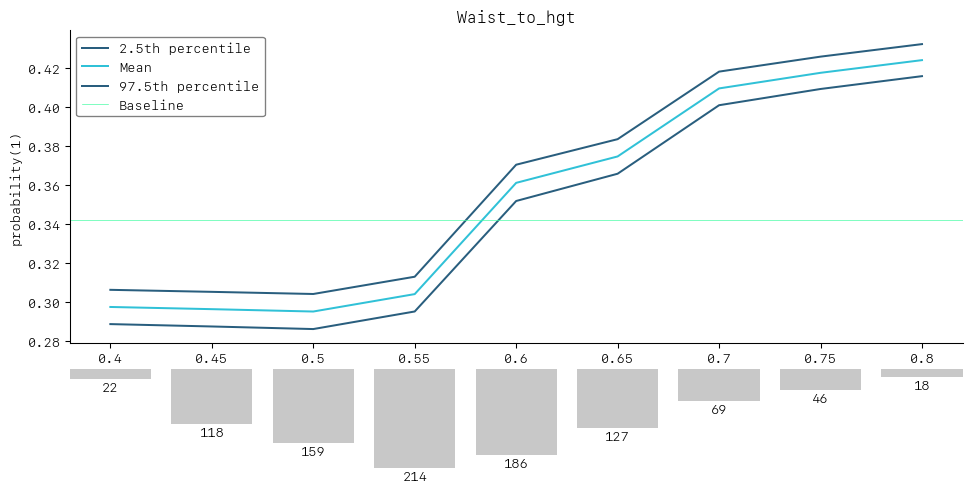

In [29]:
# visualize the results
SimulationDrawer().draw(data=waist_to_hgt_simulation, title=sim_feature)

As we can see the simulation shows that higher waist to height ratios are associated with an increased risk of prediabetes. We could also suggest that keeping a person's waist to height ratio below 0.52 may reduce the likelihood of prediabetes from around 34% to 30%.

In [30]:
# can also get a print out of simulation results
SimulationDrawer("text").draw(data=waist_to_hgt_simulation, title=sim_feature)

================================= Waist_to_hgt =================================


probability(1):

Baseline = 0.342

Partition  2.5th percentile  Mean       97.5th percentile
=========  ================  =========  =================
0.4                0.289      0.297              0.306   
0.45               0.287      0.296              0.305   
0.5                0.286      0.295              0.304   
0.55               0.295      0.304              0.313   
0.6                0.352      0.361              0.37    
0.65               0.366      0.375              0.383   
0.7                0.401      0.409              0.418   
0.75               0.409      0.417              0.426   
0.8                0.416      0.424              0.432   

Observed frequencies:

Partition  Frequency
=========  =========
0.4               22
0.45             118
0.5              159
0.55             214
0.6              186
0.65             127
0.7               69
0.75              46
0.8       

# Summary

With the capabilities offered by FACET we were able to:

1. Identify a learner with performance comparable to models in the literature.
2. Utilize advanced the SHAP value capabilities (synergy and redundancy) to identify additional features that could be removed (i.e., BMI and waist circumference removed in favour of waist to height ratio) and whether any features had strong synergistic effects - which they did not.
3. Simulate the effect of changes in waist to height ratio on the likelihood of being prediabetic.

# What can you do next?

There are several next/alternative steps that could be taken:

1. Utilize methods to deal with class imbalance and see if it improves the model.
2. Adding more features! The NHANES data is a treasure trove of information.
3. Retain diabetic patients and convert it into a multi-class learning problem.
4. What would happen if we applied survey weights when constructing a learner?
5. Further investigation of feature engineering. One could also look at different sets of measurements such as the bio-profile and perform dimension reduction first via PCA or some other method.
6. Other learners such as SVC, LDA, Elastic-Net, CNN.
7. More sophisticated imputation for missing values: the assumption of MAR might not hold, as those with worse health and thus more at risk of prediabetes may be more likely not to disclose poor health characteristics. Methods enabled by IterativeImputer could be used or even KNNImputer. Also feature engineering could be done post imputation in the pipeline, so values such as ratios are consistent. 

# Appendix

## Data source and study cohort

**Introduction**  
Prediabetes is a treatable condition that leads to many health complications, including eventually type 2 diabetes. Prediabetes has become an epidemic worldwide and is increasing in prevalence. As a largely asymptomatic condition, screening for prediabetes can be extremely challenging. However, early intervention, especially with lifestyle changes has been shown as effective in treating prediabetes. Accurate prediction/identification of those individuals at risk of prediabetes can improve early intervention and may provide insights into those interventions that work best. The current standard of care is a CDC prediabetes risk [screening tool](https://www.cdc.gov/diabetes/prevention/pdf/Prediabetes-Risk-Test-Final.pdf). 

**Data source**  
The dataset used in this tutorial is derived from the [National Health and Nutrition Examination Survey (NHANES) 2013-14 cross-sectional survey](https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Examination&CycleBeginYear=2013). In brief, NHANES collects demographic, socioeconomic, dietary, health, medical, dental, physiological and laboratory data on a nationally representative sample of noninstitutionalized, civilian United States residents. Please note the set-up for this data loosely follows the approach in [De Silva et al](https://pubmed.ncbi.nlm.nih.gov/31889178/).

**Patient cohort**  
In the NHANES data sub-sets of those surveyed may undergo a plasma glucose (FPG) test, oral glucose tolerance
test (OGTT), or have glycated haemoglobin (HbA1c) measured. Diabetic patients were defined as those with any of the following: FPG >= 126 mg/dl, OGTT > 200 mg/dl, HbA1c > 6.4% or a Doctor diagnosed diabetes. The created dataset contains selected information for 4356 patients aged 20 years or over who were not considered diabetic or who were not pregnant or suspected to be pregnant at the time of the survey.

**Learning target: prediabetes status**  
Using any of the available FPG, OGTT and HbA1c tests we defined patients as prediabetic where any of the following was satisfied: FPG 100–125 mg/dl, OGTT 140–200 mg/dl, or HbA1c 5.7–6.4%. Among this cohort 35% were prediabetic (n=1509).

**Initial features**  
The following tables provides an overview of the 37 features included in the example dataset.

|Instrument	|Data File Name (File)	| NHANES Field	| Description | Dataset name | Type |
| :-- | :-- | :-- | :-- | :-- | :-- |
|Demographics|Demographic Variables, Sample Weights (DEMO_H)|RIDAGEYR|Age in years at screening|Age|Numeric|
|Demographics|Demographic Variables, Sample Weights (DEMO_H)|RIAGENDR|Gender|Gender| Categorical|
|Examination|Body Measures (BMX_H)|BMXWT|Weight (kg)|Weight|Numeric|
|Examination|Body Measures (BMX_H)|BMXHT|Standing Height (cm)|Standing_Height|Numeric|
|Examination|Body Measures (BMX_H)|BMXWAIST|Waist Circumference (cm)|Waist_Circumference|Numeric|
|Examination|Body Measures (BMX_H)|BMXBMI|Body Mass Index (kg/m^2)|BMI|Numeric|
|Examination|Blood Pressure (BPX_H)|BPXSY1 to 4|Systolic: Blood pres mm Hg|Average_SBP| Numeric|
|Examination|Blood Pressure (BPX_H)|BPXDI1 to 4|Diastolic: Blood pres mm Hg|Average_DBP| Numeric|
|Questionnaire|Blood Pressure & Cholesterol (BPQ_H)|BPQ020|Ever told you had high blood pressure|High_BP| Categorical|
|Questionnaire|Diet Behavior & Nutrition (DBQ_H)|DBQ700|How healthy is the diet|Healthy_diet| Categorical|
|Questionnaire|Diabetes (DIQ_H)|DIQ175A|Family history|Family_hist_diab| Categorical|
|Questionnaire|Diabetes (DIQ_H)|DIQ172|Feel could be at risk for diabetes|Feel_at_risk_diab| Categorical|
|Questionnaire|Current Health Status (HSQ_H)|HSD010|General health condition|General_health| Categorical|
|Questionnaire|Medical Conditions (MCQ_H)|MCQ080|Doctor ever said you were overweight|Told_overweight| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ605|Vigorous work activity|Vigorous_work_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ620|Moderate work activity|Moderate_work_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ635|Walk or bicycle|Walk_or_bicycle| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ650|Vigorous recreational activities|Vigorous_rec_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ665|Moderate recreational activities|Moderate_rec_activity| Categorical|
|Questionnaire|Sleep Disorders (SLQ_H)|SLD010H|How much sleep do you get (hours)?|Sleep_hours| Numeric|
|Questionnaire|Sleep Disorders (SLQ_H)|SLQ050|Ever told doctor had trouble sleeping?|Trouble_sleeping| Categorical|
|Questionnaire|Sleep Disorders (SLQ_H)|SLQ060|Ever told by doctor have sleep disorder?|Sleep_disorder| Categorical|
|Questionnaire|Weight History (WHQ_H)|WHQ070|Tried to lose weight in past year|Tried_weight_loss_past_year| Categorical|
|Laboratory|Cholesterol HDL (HDL_H)|LBDHDD|Direct HDL-Cholesterol (mg/dL)|HDL_Cholesterol| Numeric|
|Laboratory|Cholesterol Total (TCHOL_H)|LBXTC|Total Cholesterol(mg/dL)|Total_Cholesterol| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXWBCSI|White blood cell count (1000 cells/uL)|WBC_count| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXRBCSI|Red blood cell count (million cells/uL)|RBC_count| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXHCT|Haematocrit (%)|Haematocrit| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSTR|Triglycerides (mg/dL)|Triglycerides| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSUA|Uric acid (mg/dL)|Uric_acid| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSOSSI|Osmolality (mmol/Kg)|Osmolality| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSNASI|Sodium (mmol/L)|Sodium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSKSI|Potassium (mmol/L)|Potassium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSGTSI|Gamma glutamyl transferase (U/L)|Gamma_glutamyl_transferase| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSCA|Total calcium (mg/dL)|Calcium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSATSI|Alanine aminotransferase ALT (IU/L)|Alanine_aminotransferase| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSASSI|Aspartate aminotransferase AST (IU/L)|Aspartate_aminotransferase| Numeric|

## Exploratory Data Analysis (EDA)

Let's begin by doing some brief exploratory data analysis to assess the impact features might have on the likelihood someone is prediabetic and to also determine what will need to be addressed in a preprocessing pipeline.

In [31]:
# load the prepared data frame
prediab_eda = pd.read_csv("pre_diab_nhanes.csv")
prediab_eda.head()

,Age,Gender,Waist_Circumference,Weight,Standing_Height,BMI,Average_SBP,Average_DBP,HDL_Cholesterol,Total_Cholesterol,...,Triglycerides,Uric_acid,Osmolality,Sodium,Potassium,Gamma_glutamyl_transferase,Calcium,Alanine_aminotransferase,Aspartate_aminotransferase,Pre_diab
0,73.0,2.0,NaN,52.0,162.4,19.7,137.333333,86.666667,85.0,201.0,...,88.0,4.2,290.0,142.0,4.1,31.0,10.0,28.0,36.0,1
1,56.0,1.0,123.1,105.0,158.7,41.7,157.333333,82.000000,38.0,226.0,...,327.0,9.1,287.0,143.0,3.3,22.0,9.3,16.0,24.0,0
2,61.0,2.0,110.8,93.4,161.8,35.7,122.666667,80.666667,58.0,168.0,...,68.0,5.1,281.0,140.0,3.9,17.0,9.9,21.0,20.0,1
3,56.0,2.0,85.5,61.8,152.8,26.5,122.000000,72.666667,59.0,278.0,...,262.0,3.5,277.0,139.0,4.0,21.0,9.5,24.0,23.0,0
4,65.0,1.0,93.7,65.3,172.4,22.0,141.333333,77.333333,79.0,173.0,...,39.0,6.3,281.0,140.0,4.8,24.0,9.5,20.0,29.0,0


We might also consider some rudimentary feature engineering as well, such as the ratio of waist circumference to height or the ratio of systolic to diastolic blood pressure. Let's create these two features as well.

In [32]:
prediab_eda["SBP_to_DBP"] = prediab_eda["Average_SBP"] / prediab_eda["Average_DBP"]
prediab_eda["Waist_to_hgt"] = (
    prediab_eda["Waist_Circumference"] / prediab_eda["Standing_Height"]
)
prediab_eda.head()

,Age,Gender,Waist_Circumference,Weight,Standing_Height,BMI,Average_SBP,Average_DBP,HDL_Cholesterol,Total_Cholesterol,...,Osmolality,Sodium,Potassium,Gamma_glutamyl_transferase,Calcium,Alanine_aminotransferase,Aspartate_aminotransferase,Pre_diab,SBP_to_DBP,Waist_to_hgt
0,73.0,2.0,NaN,52.0,162.4,19.7,137.333333,86.666667,85.0,201.0,...,290.0,142.0,4.1,31.0,10.0,28.0,36.0,1,1.584615,NaN
1,56.0,1.0,123.1,105.0,158.7,41.7,157.333333,82.000000,38.0,226.0,...,287.0,143.0,3.3,22.0,9.3,16.0,24.0,0,1.918699,0.775677
2,61.0,2.0,110.8,93.4,161.8,35.7,122.666667,80.666667,58.0,168.0,...,281.0,140.0,3.9,17.0,9.9,21.0,20.0,1,1.520661,0.684796
3,56.0,2.0,85.5,61.8,152.8,26.5,122.000000,72.666667,59.0,278.0,...,277.0,139.0,4.0,21.0,9.5,24.0,23.0,0,1.678899,0.559555
4,65.0,1.0,93.7,65.3,172.4,22.0,141.333333,77.333333,79.0,173.0,...,281.0,140.0,4.8,24.0,9.5,20.0,29.0,0,1.827586,0.543503


In [33]:
# first a quick look at features overall
prediab_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4356.0,47.044536,17.188703,20.000000,33.000000,45.000000,61.000000,80.000000
Gender,4356.0,1.521350,0.499601,1.000000,1.000000,2.000000,2.000000,2.000000
Waist_Circumference,4158.0,97.167268,15.799909,55.500000,85.900000,95.500000,106.500000,177.900000
Weight,4321.0,79.939968,21.135093,32.300000,65.100000,76.900000,91.100000,222.600000
Standing_Height,4318.0,167.369701,10.158315,136.300000,160.000000,167.100000,174.500000,199.400000
BMI,4314.0,28.446639,6.793577,14.100000,23.700000,27.300000,31.800000,82.900000
Average_SBP,4229.0,121.893671,17.271841,64.666667,110.000000,118.666667,131.333333,228.000000
Average_DBP,4222.0,70.280515,11.039221,22.666667,63.333333,70.666667,77.333333,128.000000
HDL_Cholesterol,4318.0,53.723020,16.240125,10.000000,42.000000,51.000000,63.000000,173.000000
Total_Cholesterol,4318.0,190.363131,39.631288,69.000000,163.000000,188.000000,214.000000,525.000000


<AxesSubplot:>

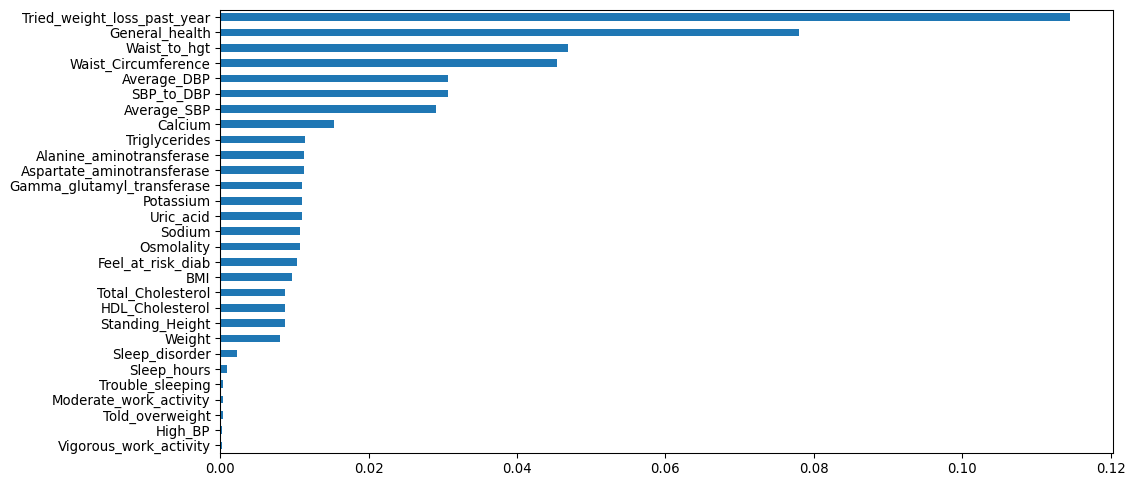

In [34]:
# missingness
miss_count = prediab_eda.isna().sum()
miss_pct = miss_count[miss_count > 0] / len(prediab_eda)
miss_pct.sort_values().plot.barh()

In [35]:
# those variables that are complete
miss_count[miss_count == 0] / len(prediab_eda)

Age                      0.0
Gender                   0.0
Family_hist_diab         0.0
Walk_or_bicycle          0.0
Vigorous_rec_activity    0.0
Moderate_rec_activity    0.0
Healthy_diet             0.0
WBC_count                0.0
RBC_count                0.0
Hematocrit               0.0
Pre_diab                 0.0
dtype: float64

<AxesSubplot:>

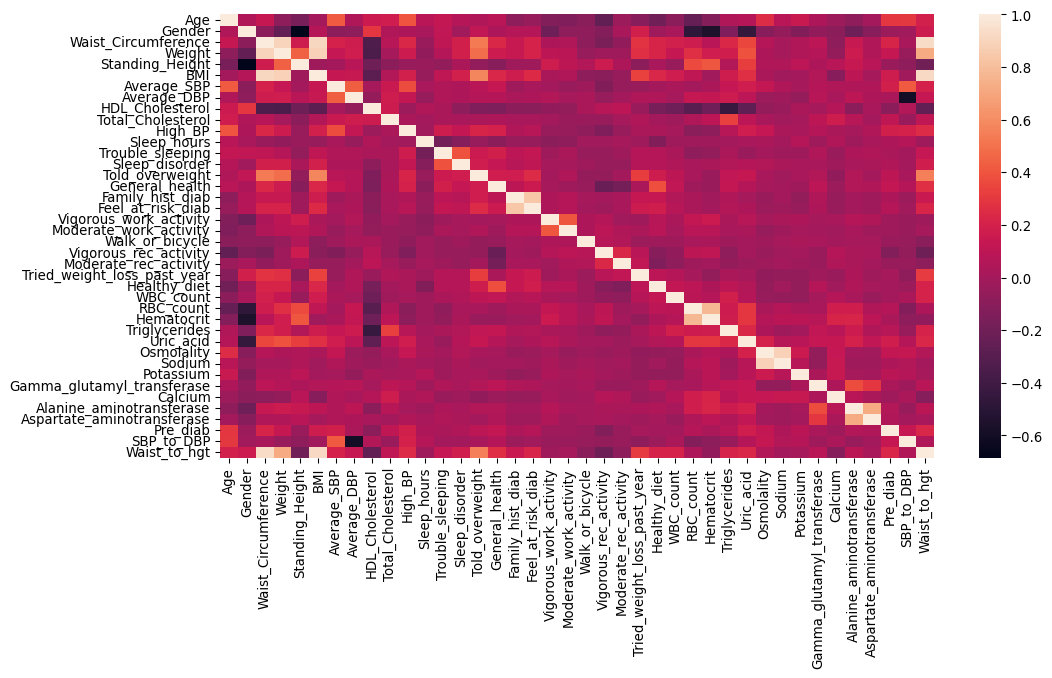

In [36]:
# view correlations with a heatmap
df_cor = prediab_eda.corr()
sns.heatmap(df_cor, xticklabels=df_cor.columns, yticklabels=df_cor.columns)

In [37]:
# let's do a table comparing features by the target

from tableone import TableOne

TableOne(
    prediab_eda,
    columns=prediab_eda.columns.drop("Pre_diab").to_list(),
    categorical=[
        "Gender",
        "High_BP",
        "Trouble_sleeping",
        "Sleep_disorder",
        "Told_overweight",
        "General_health",
        "Family_hist_diab",
        "Feel_at_risk_diab",
        "Vigorous_work_activity",
        "Moderate_work_activity",
        "Walk_or_bicycle",
        "Vigorous_rec_activity",
        "Moderate_rec_activity",
        "Tried_weight_loss_past_year",
        "Healthy_diet",
    ],
    groupby="Pre_diab",
    pval=True,
    remarks=False,
    overall=False,
)

Grouped by Pre_diab                                     
                                                      Missing             0              1 P-Value
n                                                                      2847           1509        
Age, mean (SD)                                              0   43.4 (16.4)    54.0 (16.4)  <0.001
Gender, n (%)                         1.0                   0   1330 (46.7)     755 (50.0)   0.040
                                      2.0                       1517 (53.3)     754 (50.0)        
Waist_Circumference, mean (SD)                            198   94.7 (15.3)   101.9 (15.7)  <0.001
Weight, mean (SD)                                          35   77.8 (20.2)    83.9 (22.2)  <0.001
Standing_Height, mean (SD)                                 38  167.6 (10.1)   166.8 (10.2)   0.014
BMI, mean (SD)                                             42    27.6 (6.4)     30.0 (7.2)  <0.001
Average_SBP, mean (SD)                                    127  119.6 (16.3)   126.3 (18.1)  <0.001
Average_DBP, mean (SD)                                    134   70.0 (10.7)    70.7 (11.7)   0.057
HDL_Cholesterol, mean (SD)                                 38   54.9 (16.6)    51.5 (15.2)  <0.001
Total_Cholesterol, mean (SD)                               38  187.2 (38.0)   196.3 (41.8)  <0.001
High_BP, n (%)                        0.0                   1   2113 (74.2)     847 (56.2)  <0.001
                                      1.0                        734 (25.8)     661 (43.8)        
Sleep_hours, mean (SD)                                      4     6.8 (1.4)      6.9 (1.5)   0.024
Trouble_sleeping, n (%)               0.0                   2   2161 (75.9)    1107 (73.4)   0.073
                                      1.0                        685 (24.1)     401 (26.6)        
Sleep_disorder, n (%)                 0.0                  10   2624 (92.4)    1349 (89.6)   0.003
                                      1.0                         217 (7.6)     156 (10.4)        
Told_overweight, n (%)                0.0                   2   2057 (72.3)     943 (62.6)  <0.001
                                      1.0                        790 (27.7)     564 (37.4)        
General_health, n (%)                 1.0                 340    317 (12.1)       94 (6.7)  <0.001
                                      2.0                        799 (30.5)     340 (24.3)        
                                      3.0                       1038 (39.6)     623 (44.6)        
                                      4.0                        403 (15.4)     293 (21.0)        
                                      5.0                          62 (2.4)       47 (3.4)        
Family_hist_diab, n (%)               0                     0   2254 (79.2)    1147 (76.0)   0.018
                                      1                          593 (20.8)     362 (24.0)        
Feel_at_risk_diab, n (%)              0.0                  45   2066 (73.3)    1001 (67.0)  <0.001
                                      1.0                        752 (26.7)     492 (33.0)        
Vigorous_work_activity, n (%)         0.0                   1   2287 (80.3)    1229 (81.5)   0.374
                                      1.0                        560 (19.7)     279 (18.5)        
Moderate_work_activity, n (%)         0.0                   2   1857 (65.2)    1022 (67.8)   0.101
                                      1.0                        989 (34.8)     486 (32.2)        
Walk_or_bicycle, n (%)                0.0                   0   2088 (73.3)    1158 (76.7)   0.016
                                      1.0                        759 (26.7)     351 (23.3)        
Vigorous_rec_activity, n (%)          0.0                   0   2033 (71.4)    1251 (82.9)  <0.001
                                      1.0                        814 (28.6)     258 (17.1)        
Moderate_rec_activity, n (%)          0.0                   0   1569 (55.1)     90

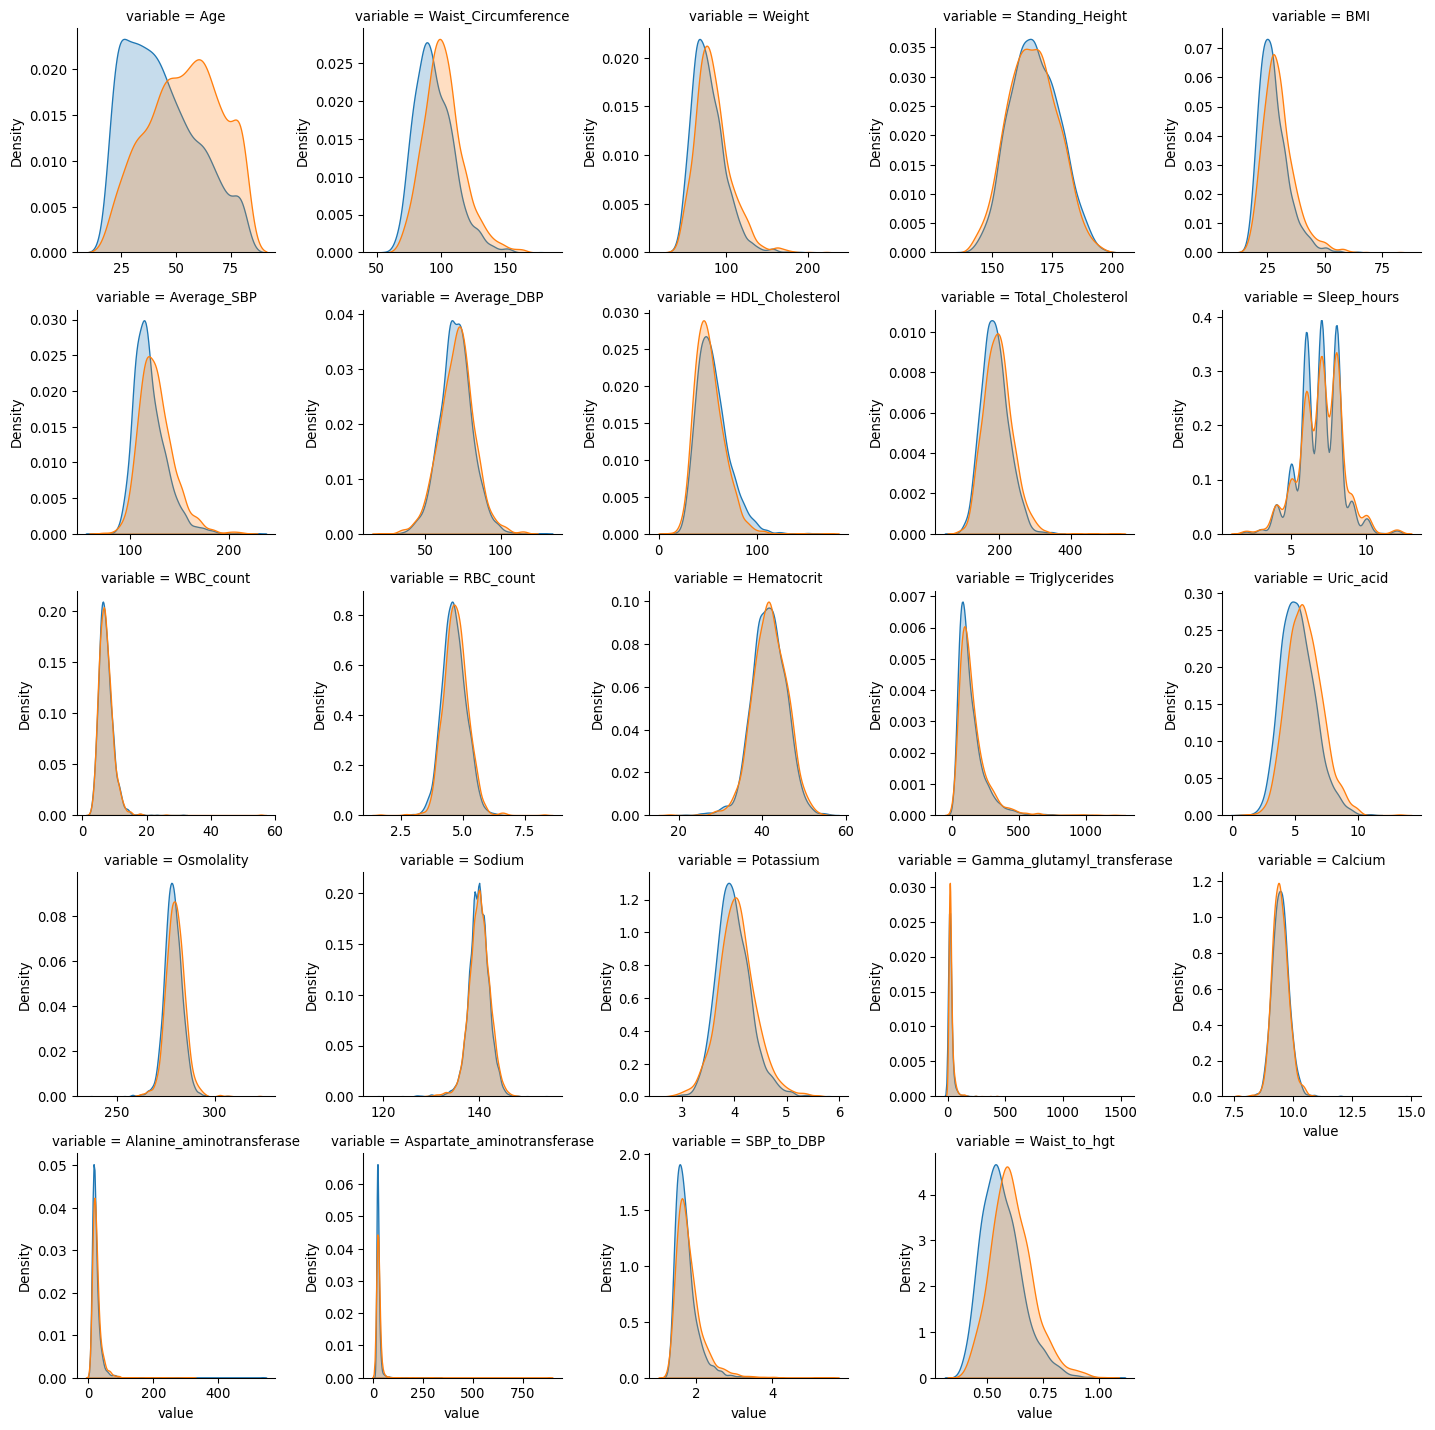

In [38]:
# KDE plots by prediabetes status as well for those continuous features
distn_vars = [
    "Age",
    "Waist_Circumference",
    "Weight",
    "Standing_Height",
    "BMI",
    "Average_SBP",
    "Average_DBP",
    "HDL_Cholesterol",
    "Total_Cholesterol",
    "Sleep_hours",
    "WBC_count",
    "RBC_count",
    "Hematocrit",
    "Triglycerides",
    "Uric_acid",
    "Osmolality",
    "Sodium",
    "Potassium",
    "Gamma_glutamyl_transferase",
    "Calcium",
    "Alanine_aminotransferase",
    "Aspartate_aminotransferase",
    "SBP_to_DBP",
    "Waist_to_hgt",
]

df_kde = pd.melt(prediab_eda[distn_vars + ["Pre_diab"]], "Pre_diab", distn_vars)
g = sns.FacetGrid(
    df_kde, col="variable", hue="Pre_diab", col_wrap=5, sharex=False, sharey=False
)
g.map(sns.kdeplot, "value", fill=True)
plt.show()

**Quick EDA summary:**

Missingness

- Our target and 10 features were complete.
- The other 29 features had levels of missing ranging from 0.02% to 11.5%, and 22 of the 29 were <3%.
- Most extreme cases of missingness were for tried weight loss in the past year (11.5%) and general health (7.8%).

Correlations

- There is a wide range of correlation among features, where we can see that for example RBC count, haematocrit and standing height are all moderately negatively correlated with gender (i.e., females are shorter), and that body measurements for weight, height, BMI, and waist circumference are all strongly positively correlated. 

Associations

- Some features already appear to not to be strongly associated based on univariate tests, such as: average DBP, trouble sleeping, vigorous work activity, moderate work activity, tried weight loss in the past year, healthy diet, WBC count, and calcium levels.
- Features associated with an increased risk of prediabetes include: older age, being male, increased waist circumference, decreased standing height, increased weight, increased BMI, increased average SBP, lower HDL cholesterol, increased total cholesterol, having high BP, increased sleep hours, having a sleep disorder, being told you are overweight, poorer general health, family history of diabetes, feeling at risk for diabetes, reduced walking or cycling, less vigorous or moderate recreational activity, higher RBC count, higher haematocrit, increased triglycerides, increased uric acid, higher osmolality, increased sodium, increased potassium, increased gamma glutamyl transferase, increased alanine aminotransferase, increased aspartate aminotransferase, increased SBP to DBP ratio, increased waist to height ratio.

Distributions of numeric features

- Many of the continuous features have been flagged as potentially non-normal/multi-modal and with potential outliers. This can be seen in the plots where many biomarkers have positive skewed distributions and in the case of sodium, some modality which could also be related to measurement.